# Batch GP Regression

## Introduction

In this notebook, we demonstrate how to train Gaussian processes in the batch setting -- that is, given `b` training sets and `b` separate test sets, GPyTorch is capable of training independent GPs on each training set and then testing each GP separately on each test set in parallel. This can be extremely useful if, for example, you would like to do k-fold cross validation.

**Note:** When operating in batch mode, we do **NOT** account for any correlations between the different functions being modeled. If you wish to do this, see the multitask examples instead.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

## Set up training data

In the next cell, we set up the training data for this example. For the x values, we'll be using 11 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels. For the training labels, we'll be modeling four functions independently in batch mode: two sine functions with different periods and two cosine functions with different periods. 

In total, `train_x` will be `4 x 100 x 1` (`b x n x 1`) and `train_y` will be `4 x 100` (`b x n`)

In [2]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100).view(1, -1, 1).repeat(4, 1, 1)
# True function is sin(2*pi*x) with Gaussian noise
sin_y = torch.sin(train_x[0] * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
sin_y_short = torch.sin(train_x[0] * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y = torch.cos(train_x[0] * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y_short = torch.cos(train_x[0] * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
train_y = torch.cat((sin_y, sin_y_short, cos_y, cos_y_short)).squeeze(-1)

## Setting up the model

The next cell adapts the model from the Simple GP regression tutorial to the batch setting. Not much changes: the only modification is that we add a `batch_size` to the mean and covariance modules. What this does internally is replicates the mean constant and lengthscales `b` times so that we learn a different value for each function in the batch.

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_size=4)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(batch_size=4), batch_size=4
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_size=4)
model = ExactGPModel(train_x, train_y, likelihood)

## Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process. This loop is nearly identical to the simple GP regression setting with one key difference. Now, the call through the mariginal log likelihood returns `b` losses, one for each GP. Since we have different parameters for each GP, we can simply sum these losses before calling `backward`.

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y).sum()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 16.613
Iter 2/50 - Loss: 15.770
Iter 3/50 - Loss: 14.921
Iter 4/50 - Loss: 14.076
Iter 5/50 - Loss: 13.241
Iter 6/50 - Loss: 12.425
Iter 7/50 - Loss: 11.637
Iter 8/50 - Loss: 10.878
Iter 9/50 - Loss: 10.129
Iter 10/50 - Loss: 9.398
Iter 11/50 - Loss: 8.699
Iter 12/50 - Loss: 8.024
Iter 13/50 - Loss: 7.340
Iter 14/50 - Loss: 6.687
Iter 15/50 - Loss: 5.954
Iter 16/50 - Loss: 5.272
Iter 17/50 - Loss: 4.678
Iter 18/50 - Loss: 3.911
Iter 19/50 - Loss: 3.255
Iter 20/50 - Loss: 2.633
Iter 21/50 - Loss: 1.999
Iter 22/50 - Loss: 1.340
Iter 23/50 - Loss: 0.734
Iter 24/50 - Loss: 0.123
Iter 25/50 - Loss: -0.441
Iter 26/50 - Loss: -0.894
Iter 27/50 - Loss: -1.469
Iter 28/50 - Loss: -1.979
Iter 29/50 - Loss: -2.391
Iter 30/50 - Loss: -2.867
Iter 31/50 - Loss: -3.188
Iter 32/50 - Loss: -3.626
Iter 33/50 - Loss: -3.907
Iter 34/50 - Loss: -4.292
Iter 35/50 - Loss: -4.468
Iter 36/50 - Loss: -4.768
Iter 37/50 - Loss: -4.809
Iter 38/50 - Loss: -5.110
Iter 39/50 - Loss: -5.076
Iter 40/50

## Make predictions with the model

Making predictions with batched GPs is straight forward: we simply call the model (and optionally the likelihood) on batch `b x t x 1` test data. The resulting `MultivariateNormal` will have a `b x n` mean and a `b x n x n` covariance matrix. Standard calls like `preds.confidence_region()` still function -- for example `preds.var()` returns a `b x n` set of predictive variances.

In the cell below, we make predictions in batch mode for the four functions and plot the GP fit for each one.

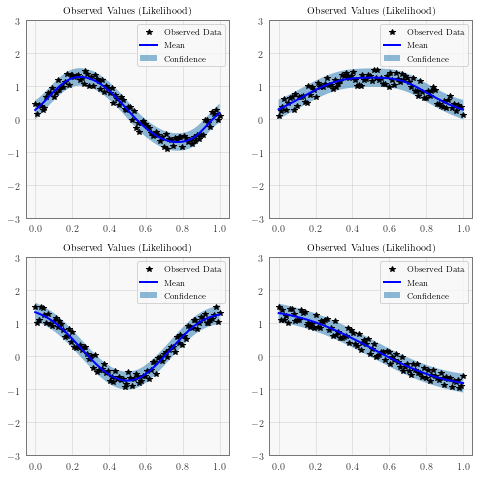

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, ((y1_ax, y2_ax), (y3_ax, y4_ax)) = plt.subplots(2, 2, figsize=(8, 8))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51).view(1, -1, 1).repeat(4, 1, 1)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()


# Plot training data as black stars
y1_ax.plot(train_x[0].detach().numpy(), train_y[0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x[0].squeeze().numpy(), mean[0, :].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x[0].squeeze().numpy(), lower[0, :].numpy(), upper[0, :].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

y2_ax.plot(train_x[1].detach().numpy(), train_y[1].detach().numpy(), 'k*')
y2_ax.plot(test_x[1].squeeze().numpy(), mean[1, :].numpy(), 'b')
y2_ax.fill_between(test_x[1].squeeze().numpy(), lower[1, :].numpy(), upper[1, :].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

y3_ax.plot(train_x[2].detach().numpy(), train_y[2].detach().numpy(), 'k*')
y3_ax.plot(test_x[2].squeeze().numpy(), mean[2, :].numpy(), 'b')
y3_ax.fill_between(test_x[2].squeeze().numpy(), lower[2, :].numpy(), upper[2, :].numpy(), alpha=0.5)
y3_ax.set_ylim([-3, 3])
y3_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y3_ax.set_title('Observed Values (Likelihood)')

y4_ax.plot(train_x[3].detach().numpy(), train_y[3].detach().numpy(), 'k*')
y4_ax.plot(test_x[3].squeeze().numpy(), mean[3, :].numpy(), 'b')
y4_ax.fill_between(test_x[3].squeeze().numpy(), lower[3, :].numpy(), upper[3, :].numpy(), alpha=0.5)
y4_ax.set_ylim([-3, 3])
y4_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y4_ax.set_title('Observed Values (Likelihood)')

None